In [2]:
# from myreport import html_report
from IPython.display import HTML
tog='''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''';

def init_esplot():
    plt.close('all');
    fig=plt.figure(figsize=[10, 4]);
    ax=plt.subplot(1,1,1)
    return(ax,fig)
HTML(tog)


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math,copy,random
import sys
%matplotlib inline


global IPTG

cmd_init_name='''
varname=['p_LacI','p_TetR','p_CI','m_LacI','m_TetR','m_CI','m_GFP','p_GFP','CIO_off','LacO_off','TetO_off'];
cstname=['k_m','k_m0','k_p','k_dm','k_dp','K','n','k_dGFP','IPTG','K_IPTG','K_TetO','k_off','cpnum','cpnum_TetO'];
'''
cmd_name2dict='''
vardict={x:varname.index(x) for x in varname};
cstdict={x:cstname.index(x) for x in cstname};
'''
make_init_cmd = lambda varname,cstname:'s0=(%s);param = (%s);'% (','.join(varname),','.join(cstname));
make_unpack_cmd = lambda varname,cstname:'(%s)=s;(%s)=param;'% (','.join(varname),','.join(cstname));
make_pack_cmd = lambda varname,cstname: 'sdot=(%s);'%(','.join(['d'+x for x in varname]))
make_unpackobs_cmd = lambda vardict:''.join( '%s_obs = s_obs[:,%s];' % (key,val) for key,val in vardict.items());

cmd_default_incond='''
p_LacI=100.
p_TetR=0
p_CI=0
p_GFP=0

m_LacI=50.
m_TetR=0
m_CI=0
m_GFP=0

CIO_off=0;
LacO_off=0.;
TetO_off=0;

'''

cmd_default_param='''

cpnum0=5.;
k_m=0.5/cpnum0;
k_m0=5e-4/cpnum0;

K=40.0
K_TetO=40.0;
n=2.1


k_off=1./318;
#k_off = 100000.;
k_on=k_off/K**n;
k_on_TetO=k_off/K_TetO**n;



k_dm=0.00577622650467
k_dp=0.00144405662617
k_dGFP=0.000128360588993
k_p=0.115524530093
IPTG=0.;
K_IPTG=6.E6;
cpnum = 5.;
cpnum_TetO = 0;
'''
exec(cmd_default_incond)
exec(cmd_default_param)

exec(cmd_init_name)
exec(cmd_name2dict)


cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
cmd_unpack_obs
# cmd_pack_all




def fft_period(ys,threshold=20, debug=1):
    X = np.array(ys)
    N=len(X)
    W    = np.fft.fft(X)/X.size
    W[0]=0;
    freq = np.fft.fftfreq(N,1)

#     threshold = 20
    absW=abs(W)
    try:
        dur = np.where(absW>threshold)[0];
        Wdur=absW[dur];
        idx = dur[np.where(Wdur == max(Wdur))[0]];
    #     idx = np.where(abs(W)>threshold)[0][-1]
#         axRa.plot(Wdur)
        max_f = abs(freq[idx])
    except:
        if debug:
            print('errored or no significant period');
        max_f = np.array(0);

    period = (1/max_f).flat[0];
    if debug:
        fig=plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.plot(1/freq[:N/2],absW[:N/2])
        print "Period estimate: ", period
    return period

def analyse(ys):
    period = fft_period(ys,debug=0)/nt;
    amp=ys.max()-ys.min()
    avg=ys[-int(period*nt):].mean();
    print('log_par = {}, period estimate: {:f}, amplitude:{:f}, mean_LacI:{:f}'.format(str(log_par),period,amp,avg))
    return((period,amp,avg))

def sdot(s,t,param):

#     (p_LacI, p_TetR, p_CI, m_LacI, m_TetR, m_CI, m_GFP, p_GFP)=s
#     (k_m, k_m0, k_p, k_dm, k_dp, K, n, k_dGFP, IPTG,fix_conc)=param
    exec(cmd_unpack_all)

#     if not fix_list==None:
#     print(fix_list)
    
#     for var_ind in fix_list:
#         cmd=varname[var_ind] + ' = (fix_conc[var_ind])';
#         exec(cmd);
#         print(cmd)
#         print(var_ind)
#     CI_bound = n*

    k_on=k_off/K**n;
    k_on_TetO=k_off/K_TetO**n;
    
    CI_free = p_CI - n*CIO_off;
    LacI_free = p_LacI - n*LacO_off;
    TetR_free = p_TetR - n*TetO_off;
    
    dCIO_off = k_on*(cpnum - CIO_off)*CI_free**n - k_off*CIO_off;
    dLacO_off = k_on*(cpnum - LacO_off)*LacI_free**n - k_off*LacO_off;
    dTetO_off = k_on_TetO*(cpnum+cpnum_TetO - TetO_off)*TetR_free**n - k_off*TetO_off;
    
    
#     dCI_bound = n*(dCIO_off);
#     dLacI_bound = n*(dLacO_off);
#     dTetR_bound = n*(dTetO_off);
    
    
#     rate_CIO = (k_m / (1. + (p_CI/K)**n) +
#                 k_m0);
#     rate_LacO = (k_m*K**n / (K**n + p_LacI**n) +
#                  k_m0);
#     rate_LacO = (k_m/ (1. + (p_LacI/K * ( 1. /(1.+IPTG/K_IPTG))**2 )**n) +
#                  k_m0);

#     rate_TetO = (k_m / (1 + (p_TetR/K_TetO)**n) +                      
#                  k_m0);
    
    rate_m_TetR_prod =  k_m0*LacO_off + k_m*(cpnum-LacO_off);
    rate_m_LacI_prod = k_m0*CIO_off + k_m*(cpnum-CIO_off);
    rate_m_CI_prod   = (k_m0*TetO_off + k_m*(cpnum+cpnum_TetO-TetO_off))*cpnum/(cpnum+cpnum_TetO);
    rate_m_GFP_prod  = 0

#     rate_m_TetR_prod = k_m*K**n / (K**n + p_LacI**n) + k_m0
#     rate_m_LacI_prod = k_m*K**n / (K**n + p_CI**n)   + k_m0
#     rate_m_CI_prod   = k_m*K**n / (K**n + p_TetR**n) + k_m0
    
    rate_p_LacI_prod = k_p*(m_LacI)
    rate_p_TetR_prod = k_p*(m_TetR)
    rate_p_CI_prod   = k_p*(m_CI)
    rate_p_GFP_prod  = 0

    rate_m_LacI_loss = k_dm*m_LacI
    rate_m_TetR_loss = k_dm*m_TetR
    rate_m_CI_loss   = k_dm*m_CI
    rate_m_GFP_loss  = 0

    rate_p_LacI_loss = k_dp*p_LacI
    rate_p_TetR_loss = k_dp*p_TetR
    rate_p_CI_loss   = k_dp*p_CI
    rate_p_GFP_loss  = 0

    dp_LacI = rate_p_LacI_prod - rate_p_LacI_loss
    dp_TetR = rate_p_TetR_prod - rate_p_TetR_loss
    dp_CI   = rate_p_CI_prod   - rate_p_CI_loss
    dp_GFP  = rate_p_GFP_prod  - rate_p_GFP_loss


    dm_LacI = rate_m_LacI_prod - rate_m_LacI_loss
    dm_TetR = rate_m_TetR_prod - rate_m_TetR_loss
    dm_CI   = rate_m_CI_prod   - rate_m_CI_loss
    dm_GFP  = rate_m_GFP_prod   - rate_m_GFP_loss

    exec(cmd_pack_all)
    return sdot

In [146]:
def sdot0(s,t,param):

#     (p_LacI, p_TetR, p_CI, m_LacI, m_TetR, m_CI, m_GFP, p_GFP)=s
#     (k_m, k_m0, k_p, k_dm, k_dp, K, n, k_dGFP, IPTG,fix_conc)=param
    exec(cmd_unpack_all)

#     if not fix_list==None:
#     print(fix_list)
    
#     for var_ind in fix_list:
#         cmd=varname[var_ind] + ' = (fix_conc[var_ind])';
#         exec(cmd);
#         print(cmd)
#         print(var_ind)
        
    dCIO_off=0;
    dLacO_off=0;
    dTetO_off=0;
    rate_CIO = (k_m / (1. + (p_CI/K)**n) +
                k_m0);
    rate_LacO = (k_m*K**n / (K**n + p_LacI**n) +
                 k_m0);
    rate_LacO = (k_m/ (1. + (p_LacI/K * ( 1. /(1.+IPTG/K_IPTG))**2 )**n) +
                 k_m0);

    rate_TetO = (k_m / (1 + (p_TetR/K_TetO)**n) +                      
                 k_m0);
    
    rate_m_TetR_prod =  rate_LacO*cpnum/(cpnum+cpnum_TetO);
    rate_m_LacI_prod = rate_CIO*cpnum;
    rate_m_CI_prod   = rate_TetO*cpnum;
    rate_m_GFP_prod  = 0

#     rate_m_TetR_prod = k_m*K**n / (K**n + p_LacI**n) + k_m0
#     rate_m_LacI_prod = k_m*K**n / (K**n + p_CI**n)   + k_m0
#     rate_m_CI_prod   = k_m*K**n / (K**n + p_TetR**n) + k_m0
    
    rate_p_LacI_prod = k_p*(m_LacI)
    rate_p_TetR_prod = k_p*(m_TetR)
    rate_p_CI_prod   = k_p*(m_CI)
    rate_p_GFP_prod  = 0

    rate_m_LacI_loss = k_dm*m_LacI
    rate_m_TetR_loss = k_dm*m_TetR
    rate_m_CI_loss   = k_dm*m_CI
    rate_m_GFP_loss  = 0

    rate_p_LacI_loss = k_dp*p_LacI
    rate_p_TetR_loss = k_dp*p_TetR
    rate_p_CI_loss   = k_dp*p_CI
    rate_p_GFP_loss  = 0

    dp_LacI = rate_p_LacI_prod - rate_p_LacI_loss
    dp_TetR = rate_p_TetR_prod - rate_p_TetR_loss
    dp_CI   = rate_p_CI_prod   - rate_p_CI_loss
    dp_GFP  = rate_p_GFP_prod  - rate_p_GFP_loss


    dm_LacI = rate_m_LacI_prod - rate_m_LacI_loss
    dm_TetR = rate_m_TetR_prod - rate_m_TetR_loss
    dm_CI   = rate_m_CI_prod   - rate_m_CI_loss
    dm_GFP  = rate_m_GFP_prod   - rate_m_GFP_loss

    exec(cmd_pack_all)
    return sdot

In [147]:
K**n

2313.8008793470804

In [148]:
# cmd_pack_param

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


log_par = 0.0, period estimate: 6666.666667, amplitude:3676.699507, mean_LacI:1122.506848
log_par = 0.0, period estimate: 6666.666667, amplitude:3676.699507, mean_LacI:1122.506848
log_par = 0.0, period estimate: 6666.666667, amplitude:3676.699507, mean_LacI:1122.506848
log_par = 0.0, period estimate: 6666.666667, amplitude:3676.699507, mean_LacI:1122.506848
log_par = 0.0, period estimate: 6666.666667, amplitude:3676.699507, mean_LacI:1122.506848


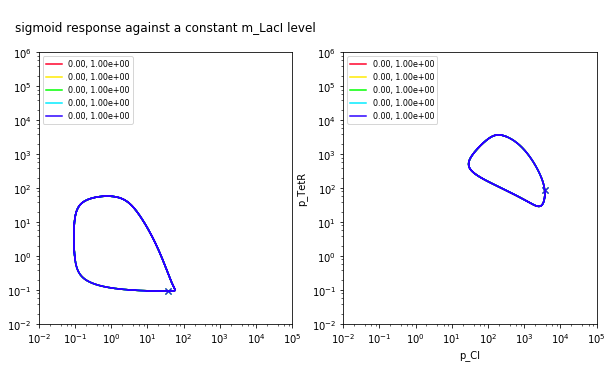

In [149]:
# sigmoid response against a constant m_LacI level
# sigmoid response against a constant m_LacI level
tl='''
sigmoid response against a constant m_LacI level
'''
dot=sdot;

fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
IPTG_method=None;
IPTG=0
    
exec(cmd_init_name)
exec(cmd_name2dict)
# parname = 'm_LacI'
# varname.pop(vardict[parname])
# cstname.append(parname)
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)


nt=1;
lc_step = 20000*nt;
# lc_step = int(t_max)

cm = plt.get_cmap('gist_rainbow')

siz=5;

# k_dp=0.0014
for i,log_par in enumerate(np.linspace(-0.,0.,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    

    exec(cmd_default_param)
    exec(cmd_default_incond)
#     m_LacI = 10**(log_par)
#     IPTG = 10**(log_par)
    exec(cmd_init_all)
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max*nt,t_max+1)
    s_obs=odeint(dot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    
    ys=p_LacI_obs;
    analyse(p_LacI_obs);

    xs = m_CI_obs;    ys = m_LacI_obs;

    axL.plot(xs,ys,color=col,label=lbl)
    axL.plot(xs[-1],ys[-1],'x',color=col)
    
    xs=p_CI_obs;ys=p_TetR_obs;
    
    axR.plot(xs,ys,color=col,label=lbl)
    axR.plot(xs[-1],ys[-1],'x',color=col)
    
axL.set_xscale('log')
axL.set_yscale('log')
axR.set_xlabel('p_CI')
axR.set_ylabel('p_LacI')
axL.set_xlim(1E-2,1E5)
axL.set_ylim(1E-2,1E6)
axL.legend(loc=2,prop={'size':8})

axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlabel('p_CI')
axR.set_ylabel('p_TetR')
axR.set_xlim(1E-2,1E5)
axR.set_ylim(1E-2,1E6)
axR.legend(loc=2,prop={'size':8})

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:45: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


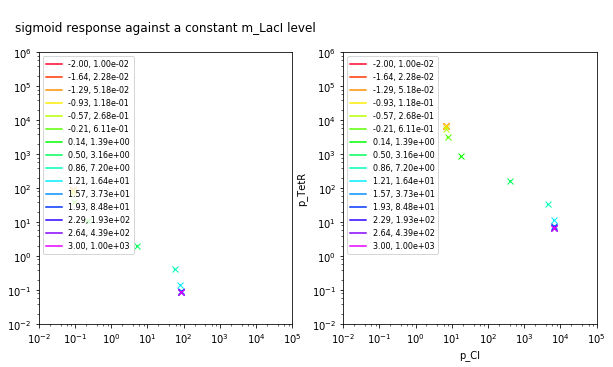

In [154]:
# sigmoid response against a constant m_LacI level
# sigmoid response against a constant m_LacI level
tl='''
sigmoid response against a constant m_LacI level
'''

fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
IPTG_method=None;
IPTG=0
    
exec(cmd_init_name)
exec(cmd_name2dict)
parname = 'm_LacI'
varname.pop(vardict[parname])
cstname.append(parname)
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)



lc_step = 20000;
# lc_step = int(t_max)

cm = plt.get_cmap('gist_rainbow')

siz=15;

# k_dp=0.0014
for i,log_par in enumerate(np.linspace(-2.,3.,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    

    exec(cmd_default_param)
    exec(cmd_default_incond)
    m_LacI = 10**(log_par)
    exec(cmd_init_all)
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,t_max+1)
    s_obs=odeint(sdot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    

    xs=p_CI_obs;ys=p_LacI_obs;
    xs = m_CI_obs;    ys = m_TetR_obs;

    axL.plot(xs,ys,color=col,label=lbl)
    axL.plot(xs[-1],ys[-1],'x',color=col)
    
    xs=p_CI_obs;ys=p_TetR_obs;
    
    axR.plot(xs,ys,color=col,label=lbl)
    axR.plot(xs[-1],ys[-1],'x',color=col)
    
axL.set_xscale('log')
axL.set_yscale('log')
axR.set_xlabel('p_CI')
axR.set_ylabel('p_LacI')
axL.set_xlim(1E-2,1E5)
axL.set_ylim(1E-2,1E6)
axL.legend(loc=2,prop={'size':8})

axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlabel('p_CI')
axR.set_ylabel('p_TetR')
axR.set_xlim(1E-2,1E5)
axR.set_ylim(1E-2,1E6)
axR.legend(loc=2,prop={'size':8})

In [155]:
cmd_unpack_obs

'p_LacI_obs = s_obs[:,0];m_TetR_obs = s_obs[:,3];LacO_off_obs = s_obs[:,8];CIO_off_obs = s_obs[:,7];p_CI_obs = s_obs[:,2];TetO_off_obs = s_obs[:,9];m_CI_obs = s_obs[:,4];p_TetR_obs = s_obs[:,1];m_GFP_obs = s_obs[:,5];p_GFP_obs = s_obs[:,6];'

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


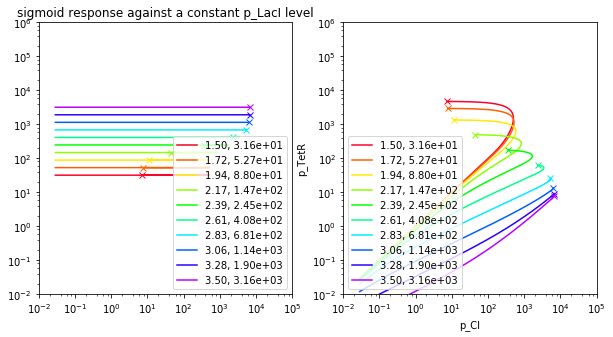

In [156]:
# sigmoid response against a constant p_LacI level
tl='sigmoid response against a constant p_LacI level';

fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);

IPTG_method=None;
IPTG=0
    
exec(cmd_init_name)
exec(cmd_name2dict)
parname = 'p_LacI'
varname.pop(vardict[parname])
cstname.append(parname)
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)


t_obs=np.linspace(0,t_max,t_max+1)

lc_step = int(t_max);

cm = plt.get_cmap('gist_rainbow')

siz=10;

# k_dp=0.0014
for i,log_par in enumerate(np.linspace(1.5,3.5,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    

    exec(cmd_default_param)
    exec(cmd_default_incond)
    p_LacI = 10**(log_par)
    exec(cmd_init_all)
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,t_max+1)
    s_obs=odeint(sdot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    

    xs=p_CI_obs;ys=len(xs)*[p_LacI];

    axL.plot(xs,ys,color=col,label=lbl)
    axL.plot(xs[-1],ys[-1],'x',color=col)
    
    xs=p_CI_obs;ys=p_TetR_obs;
    
    axR.plot(xs,ys,color=col,label=lbl)
    axR.plot(xs[-1],ys[-1],'x',color=col)


axL.set_xscale('log')
axL.set_yscale('log')
axR.set_xlabel('p_CI')
axR.set_ylabel('p_LacI')
axL.set_xlim(1E-2,1E5)
axL.set_ylim(1E-2,1E6)
axL.legend()

axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlabel('p_CI')
axR.set_ylabel('p_TetR')
axR.set_xlim(1E-2,1E5)
axR.set_ylim(1E-2,1E6)
axR.legend()

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


log_par = -3.0, period estimate: 10000.000000, amplitude:4135.509533
log_par = -2.89285714286, period estimate: 10000.000000, amplitude:3862.898221
log_par = -2.78571428571, period estimate: 6666.666667, amplitude:3458.867693
log_par = -2.67857142857, period estimate: 5000.000000, amplitude:2993.088962
log_par = -2.57142857143, period estimate: 4000.000000, amplitude:2513.410555
log_par = -2.46428571429, period estimate: 4000.000000, amplitude:2051.309268
log_par = -2.35714285714, period estimate: 3333.333333, amplitude:1629.717119
log_par = -2.25, period estimate: 2857.142857, amplitude:1265.749146
log_par = -2.14285714286, period estimate: 2500.000000, amplitude:966.981236
log_par = -2.03571428571, period estimate: 2222.222222, amplitude:730.948097
log_par = -1.92857142857, period estimate: 2000.000000, amplitude:549.326163
log_par = -1.82142857143, period estimate: 1818.181818, amplitude:411.880009
log_par = -1.71428571429, period estimate: 1666.666667, amplitude:308.618398
log_par 

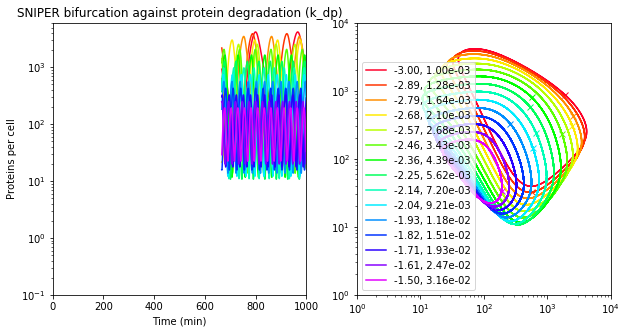

In [ ]:
### SNIPER bifurcation against protein degradation (k_dp)
tl='SNIPER bifurcation against protein degradation (k_dp)';
fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
cm = plt.get_cmap('gist_rainbow')

IPTG=0;
exec(cmd_init_name)
# var_ind=vardict['p_LacI'];
# varname.pop(var_ind);
# cstname.append('p_LacI');
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
nt=4;
lc_step = 20000*nt;



siz=15;


for i,log_par in enumerate(np.linspace(-3.,-1.5,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    exec(cmd_default_param)
    exec(cmd_default_incond)
    k_dp=10**(log_par)
    exec(cmd_init_all)
    
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,nt*t_max+1)
    s_obs=odeint(sdot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    ys=p_LacI_obs;
    period = fft_period(ys,debug=0)/nt;
    amp=ys.max()-ys.min()
    print('log_par = {}, period estimate: {:f}, amplitude:{:f}'.format(str(log_par),period,amp))
    


    axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)
#     axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
#     axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
    #     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axR.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    
axL.set_xlim(1E-1,1000)
axL.set_ylim(1E-1,6000)
axL.set_yscale('log')
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
# axL.legend()
axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlim(1,1E4)
axR.set_ylim(1,1E4)
axR.legend()

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


log_par = 1.0, period estimate: 6666.666667, amplitude:778.197423, mean_LacI:325.044312
log_par = 3.07142857143, period estimate: 6666.666667, amplitude:2321.372209, mean_LacI:699.236508
log_par = 5.14285714286, period estimate: 6666.666667, amplitude:3774.364431, mean_LacI:1149.148562
log_par = 7.21428571429, period estimate: 6666.666667, amplitude:5153.208712, mean_LacI:1266.679418
log_par = 9.28571428571, period estimate: 6666.666667, amplitude:6470.936888, mean_LacI:986.725094
log_par = 11.3571428571, period estimate: 10000.000000, amplitude:7738.421119, mean_LacI:1624.660579
log_par = 13.4285714286, period estimate: 10000.000000, amplitude:8964.443942, mean_LacI:1870.176565
log_par = 15.5, period estimate: 10000.000000, amplitude:10156.030478, mean_LacI:2130.327051
log_par = 17.5714285714, period estimate: 10000.000000, amplitude:11318.801865, mean_LacI:2393.213962
log_par = 19.6428571429, period estimate: 10000.000000, amplitude:12457.277190, mean_LacI:2661.323806
log_par = 21.71

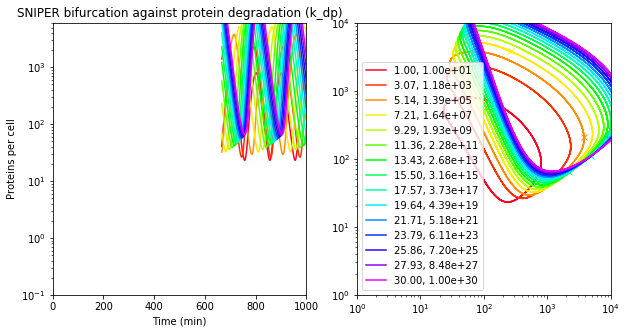

In [7]:
### SNIPER bifurcation against protein degradation (k_dp)
tl='SNIPER bifurcation against protein degradation (k_dp)';
fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
cm = plt.get_cmap('gist_rainbow')

IPTG=0;
exec(cmd_init_name)
# var_ind=vardict['p_LacI'];
# varname.pop(var_ind);
# cstname.append('p_LacI');
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
nt=4;
lc_step = 20000*nt;



siz=15;


for i,log_par in enumerate(np.linspace(1,30,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    exec(cmd_default_param)
    exec(cmd_default_incond)
#     k_dp=10**(log_par)
    cpnum = log_par;
#     cpnum = 10**log_par
    exec(cmd_init_all)
    
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,nt*t_max+1)
    s_obs=odeint(sdot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    ys=p_LacI_obs;
    analyse(ys);
    


    axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)
#     axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
#     axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
    #     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axR.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    
axL.set_xlim(1E-1,1000)
axL.set_ylim(1E-1,6000)
axL.set_yscale('log')
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
# axL.legend()
axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlim(1,1E4)
axR.set_ylim(1,1E4)
axR.legend()

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:145: RuntimeWarning: invalid value encountered in double_scalars
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:94: RuntimeWarning: invalid value encountered in greater
/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:105: RuntimeWarning: divide by zero encountered in divide


log_par = -5.0, period estimate: 0.000000, amplitude:nan, mean_LacI:nan
log_par = -4.5, period estimate: 0.000000, amplitude:nan, mean_LacI:nan
log_par = -4.0, period estimate: 0.000000, amplitude:nan, mean_LacI:nan
log_par = -3.5, period estimate: 6666.666667, amplitude:6234.265706, mean_LacI:2461.700080
log_par = -3.0, period estimate: 6666.666667, amplitude:6233.969343, mean_LacI:2460.989133
log_par = -2.5, period estimate: 6666.666667, amplitude:6232.963890, mean_LacI:2458.667935
log_par = -2.0, period estimate: 6666.666667, amplitude:6229.352169, mean_LacI:2451.030155
log_par = -1.5, period estimate: 6666.666667, amplitude:6215.559453, mean_LacI:2426.134327
log_par = -1.0, period estimate: 6666.666667, amplitude:6164.311388, mean_LacI:2350.785189
log_par = -0.5, period estimate: 6666.666667, amplitude:6020.275772, mean_LacI:2174.593172
log_par = 0.0, period estimate: 6666.666667, amplitude:5767.671147, mean_LacI:1944.073255
log_par = 0.5, period estimate: 6666.666667, amplitude:54

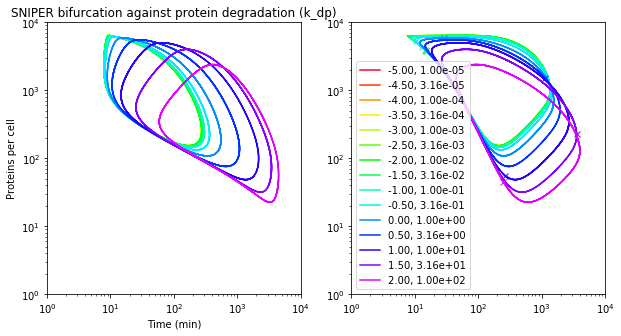

In [19]:
### SNIPER bifurcation against protein degradation (k_dp)
tl='SNIPER bifurcation against protein degradation (k_dp)';
dot=sdot;
fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
cm = plt.get_cmap('gist_rainbow')


IPTG=0;
exec(cmd_init_name)
# var_ind=vardict['p_LacI'];
# varname.pop(var_ind);
# cstname.append('p_LacI');
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
nt=4;
lc_step = 20000*nt;



siz=15;


for i,log_par in enumerate(np.linspace(-5,2,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    exec(cmd_default_param)
    exec(cmd_default_incond)
#     k_dp=10**(log_par)
#     cpnum = log_par;
    K_TetO = 10**log_par
#     cpnum = 10**log_par
    exec(cmd_init_all)
    
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,nt*t_max+1)
    s_obs=odeint(dot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    ys=p_LacI_obs;
    period = fft_period(ys,debug=0)/nt;
    amp=ys.max()-ys.min()
    avg=ys[-int(period*nt):].mean();
    print('log_par = {}, period estimate: {:f}, amplitude:{:f}, mean_LacI:{:f}'.format(str(log_par),period,amp,avg))
    


    axL.plot(p_TetR_obs,p_LacI_obs,'r',label = 'LacI',color=col)
#     axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
#     axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
    #     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axR.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    
axL.set_xlim(1,1E4)
axL.set_ylim(1,1E4)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
# axL.legend()
axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlim(1,1E4)
axR.set_ylim(1,1E4)
axR.legend()

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


log_par = 0.0, period estimate: 6666.666667, amplitude:5352.109777, mean_LacI:2044.949823
log_par = 0.388888888889, period estimate: 6666.666667, amplitude:5422.528485, mean_LacI:2047.207992
log_par = 0.777777777778, period estimate: 6666.666667, amplitude:5505.132701, mean_LacI:1849.379918
log_par = 1.16666666667, period estimate: 10000.000000, amplitude:5523.129702, mean_LacI:1498.063874
log_par = 1.55555555556, period estimate: 10000.000000, amplitude:5348.665695, mean_LacI:1220.309350
log_par = 1.94444444444, period estimate: 10000.000000, amplitude:4795.308580, mean_LacI:958.130560
log_par = 2.33333333333, period estimate: 6666.666667, amplitude:3723.900600, mean_LacI:506.437051
log_par = 2.72222222222, period estimate: 6666.666667, amplitude:2236.780429, mean_LacI:510.133340
log_par = 3.11111111111, period estimate: 6666.666667, amplitude:854.244343, mean_LacI:188.860951
log_par = 3.5, period estimate: 0.000000, amplitude:24.176327, mean_LacI:20.685874


/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:105: RuntimeWarning: divide by zero encountered in divide


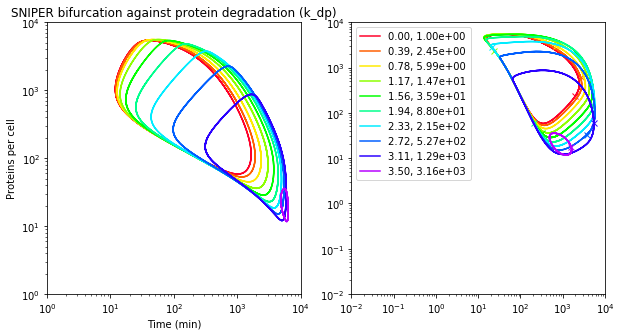

In [21]:
### SNIPER bifurcation against protein degradation (k_dp)
tl='SNIPER bifurcation against protein degradation (k_dp)';
dot=sdot;
fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
cm = plt.get_cmap('gist_rainbow')

IPTG=0;
exec(cmd_init_name)
# var_ind=vardict['p_LacI'];
# varname.pop(var_ind);
# cstname.append('p_LacI');
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
nt=1;
lc_step = 20000*nt;
# lc_step = int(t_max*nt);



siz=10;


for i,log_par in enumerate(np.linspace(0,3.5,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    exec(cmd_default_param)
    exec(cmd_default_incond)
    K_TetO=5-.;
    cpnum_TetO=10**log_par;
#     k_dp=10**(log_par)
#     cpnum = log_par;
#     K_TetO = log_par
#     cpnum = 10**log_par
    exec(cmd_init_all)
    
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,nt*t_max+1)
    s_obs=odeint(dot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    ys=p_LacI_obs;
    analyse(ys)


    axL.plot(p_TetR_obs,p_LacI_obs,'r',label = 'LacI',color=col)
#     axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
#     axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
    #     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axR.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    
axL.set_xlim(1,1E4)
axL.set_ylim(1,1E4)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
# axL.legend()lc_step = 20000*nt;

axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlim(1E-2,1E4)
axR.set_ylim(1E-2,1E4)
axR.legend()

In [18]:
plt.close('all')

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


log_par = 0.0, period estimate: 6666.666667, amplitude:5280.407960, mean_LacI:2016.371466
log_par = 2.85714285714, period estimate: 6666.666667, amplitude:5280.407960, mean_LacI:2016.371466
log_par = 5.71428571429, period estimate: 6666.666667, amplitude:5280.407960, mean_LacI:2016.371466
log_par = 8.57142857143, period estimate: 6666.666667, amplitude:5280.407960, mean_LacI:2016.371466
log_par = 11.4285714286, period estimate: 6666.666667, amplitude:5280.407960, mean_LacI:2016.371466
log_par = 14.2857142857, period estimate: 6666.666667, amplitude:5280.407960, mean_LacI:2016.371466
log_par = 17.1428571429, period estimate: 6666.666667, amplitude:5280.407960, mean_LacI:2016.371466
log_par = 20.0, period estimate: 6666.666667, amplitude:5280.407960, mean_LacI:2016.371466
log_par = 22.8571428571, period estimate: 6666.666667, amplitude:5280.407960, mean_LacI:2016.371466
log_par = 25.7142857143, period estimate: 6666.666667, amplitude:5280.407960, mean_LacI:2016.371466
log_par = 28.571428

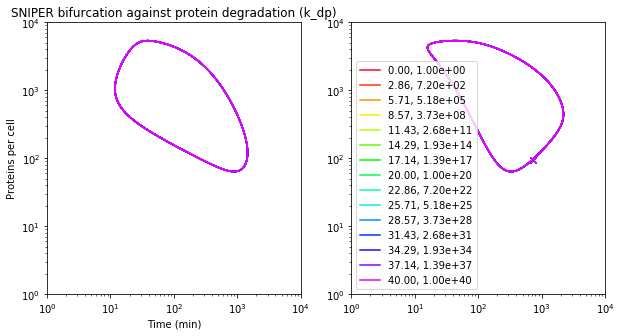

In [22]:
### SNIPER bifurcation against protein degradation (k_dp)
tl='SNIPER bifurcation against protein degradation (k_dp)';
dot=sdot
fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
cm = plt.get_cmap('gist_rainbow')

IPTG=0;
exec(cmd_init_name)
# var_ind=vardict['p_LacI'];
# varname.pop(var_ind);
# cstname.append('p_LacI');
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
nt=4;
lc_step = 20000*nt;



siz=15;


for i,log_par in enumerate(np.linspace(0,40,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    exec(cmd_default_param)
    exec(cmd_default_incond)
#     k_dp=10**(log_par)
#     cpnum = log_par;
    K_TetO = 5;
    
#     cpnum = 10**log_par
    exec(cmd_init_all)
    
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,nt*t_max+1)
    s_obs=odeint(dot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    ys=p_LacI_obs;
    period = fft_period(ys,debug=0)/nt;
    amp=ys.max()-ys.min()
    avg=ys[-int(period*nt):].mean();
    print('log_par = {}, period estimate: {:f}, amplitude:{:f}, mean_LacI:{:f}'.format(str(log_par),period,amp,avg))
    


    axL.plot(p_TetR_obs,p_LacI_obs,'r',label = 'LacI',color=col)
#     axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
#     axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
    #     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axR.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    
axL.set_xlim(1,1E4)
axL.set_ylim(1,1E4)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
# axL.legend()
axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlim(1,1E4)
axR.set_ylim(1,1E4)
axR.legend()

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


log_par = 0.1, period estimate: 10000.000000, amplitude:2476.246803, mean_LacI:597.986659
log_par = 1.075, period estimate: 10000.000000, amplitude:3239.988506, mean_LacI:848.247842
log_par = 2.05, period estimate: 6666.666667, amplitude:3852.034499, mean_LacI:1213.719925
log_par = 3.025, period estimate: 5000.000000, amplitude:3251.926944, mean_LacI:2104.812365
log_par = 4.0, period estimate: 0.000000, amplitude:0.000000, mean_LacI:5425.689557


/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:105: RuntimeWarning: divide by zero encountered in divide


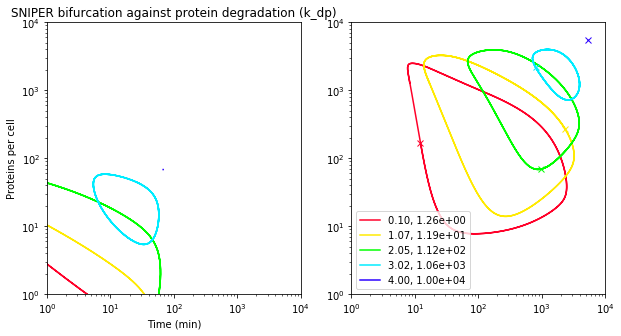

In [23]:
### SNIPER bifurcation against protein degradation (k_dp)
tl='SNIPER bifurcation against protein degradation (k_dp)';
dot=sdot;

fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
cm = plt.get_cmap('gist_rainbow')

IPTG=0;
exec(cmd_init_name)
# var_ind=vardict['p_LacI'];
# varname.pop(var_ind);
# cstname.append('p_LacI');
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
nt=4;
lc_step = 20000*nt;



siz=5;


for i,log_par in enumerate(np.linspace(0.1,4,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    exec(cmd_default_param)
    exec(cmd_default_incond)
#     k_dp=10**(log_par)
#     cpnum = log_par;
#     K_TetO = log_par
    K = 10**log_par;
#     K = log_par
    K_TetO = K;
#     cpnum = 10**log_par
    exec(cmd_init_all)
    
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,nt*t_max+1)
    s_obs=odeint(dot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    ys=p_LacI_obs;
    period = fft_period(ys,debug=0)/nt;
    amp=ys.max()-ys.min()
    avg=ys[-int(period*nt):].mean();
    print('log_par = {}, period estimate: {:f}, amplitude:{:f}, mean_LacI:{:f}'.format(str(log_par),period,amp,avg))
    

    xs = m_TetR_obs
    ys = m_LacI_obs
    axL.plot(xs,ys,'r',label = lbl,color=col)
#     axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
#     axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
    #     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axR.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    
axL.set_xlim(1,1E4)
axL.set_ylim(1,1E4)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
# axL.legend()
axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlim(1,1E4)
axR.set_ylim(1,1E4)
axR.legend()

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


log_par = 40.0, period estimate: 6666.666667, amplitude:3676.699427, mean_LacI:1122.422379
log_par = 45.7142857143, period estimate: 6666.666667, amplitude:3708.754102, mean_LacI:1140.777345
log_par = 51.4285714286, period estimate: 6666.666667, amplitude:3734.415087, mean_LacI:1148.139991
log_par = 57.1428571429, period estimate: 6666.666667, amplitude:3755.398254, mean_LacI:1133.905414
log_par = 62.8571428571, period estimate: 6666.666667, amplitude:3772.859958, mean_LacI:1090.961269
log_par = 68.5714285714, period estimate: 6666.666667, amplitude:3787.604939, mean_LacI:1076.389353
log_par = 74.2857142857, period estimate: 6666.666667, amplitude:3800.210084, mean_LacI:1124.839091
log_par = 80.0, period estimate: 6666.666667, amplitude:3811.098384, mean_LacI:1173.128713


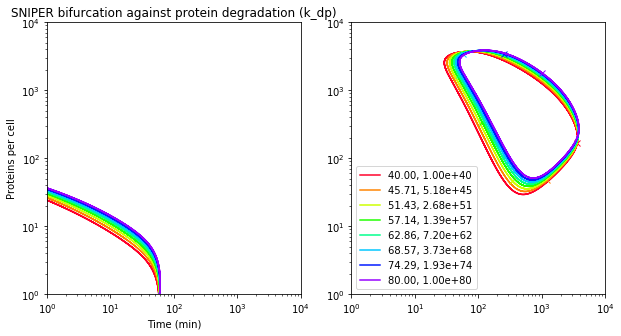

In [24]:
### SNIPER bifurcation against protein degradation (k_dp)
tl='SNIPER bifurcation against protein degradation (k_dp)';
dot=sdot;

fig1 = plt.figure(figsize=(10,5))
axL=fig1.add_subplot(1,2,1)
axR=fig1.add_subplot(1,2,2)
axL.set_title(tl);
cm = plt.get_cmap('gist_rainbow')

IPTG=0;
exec(cmd_init_name)
# var_ind=vardict['p_LacI'];
# varname.pop(var_ind);
# cstname.append('p_LacI');
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
nt=4;
lc_step = 20000*nt;



siz=8;


for i,log_par in enumerate(np.linspace(40,80,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    exec(cmd_default_param)
    exec(cmd_default_incond)
#     k_dp=10**(log_par)
#     cpnum = log_par;
#     K_TetO = log_par
#     K = 10**log_par;
    K = log_par
    K_TetO = K;
#     cpnum = 10**log_par
    exec(cmd_init_all)
    
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,nt*t_max+1)
    s_obs=odeint(dot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    ys=p_LacI_obs;
    period = fft_period(ys,debug=0)/nt;
    amp=ys.max()-ys.min()
    avg=ys[-int(period*nt):].mean();
    print('log_par = {}, period estimate: {:f}, amplitude:{:f}, mean_LacI:{:f}'.format(str(log_par),period,amp,avg))
    

    xs = m_TetR_obs
    ys = m_LacI_obs
    axL.plot(xs,ys,'r',label = lbl,color=col)
#     axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
#     axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
    #     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axR.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    
axL.set_xlim(1,1E4)
axL.set_ylim(1,1E4)
axL.set_xscale('log')
axL.set_yscale('log')
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
# axL.legend()
axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlim(1,1E4)
axR.set_ylim(1,1E4)
axR.legend()

/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


log_par = 1.0, period estimate: 5714.285714, amplitude:778.201025, mean_LacI:260.493587
log_par = 22.3571428571, period estimate: 8000.000000, amplitude:13918.315965, mean_LacI:3652.166948
log_par = 43.7142857143, period estimate: 10000.000000, amplitude:24708.604219, mean_LacI:7326.534170
log_par = 65.0714285714, period estimate: 10000.000000, amplitude:34943.796655, mean_LacI:8271.450538
log_par = 86.4285714286, period estimate: 10000.000000, amplitude:44985.641021, mean_LacI:10387.696377
log_par = 107.785714286, period estimate: 10000.000000, amplitude:54948.842082, mean_LacI:12987.554141
log_par = 129.142857143, period estimate: 10000.000000, amplitude:64878.656544, mean_LacI:15669.821979
log_par = 150.5, period estimate: 10000.000000, amplitude:74795.175340, mean_LacI:18423.709518
log_par = 171.857142857, period estimate: 10000.000000, amplitude:84707.867454, mean_LacI:21238.196485
log_par = 193.214285714, period estimate: 10000.000000, amplitude:94621.283720, mean_LacI:24092.6304

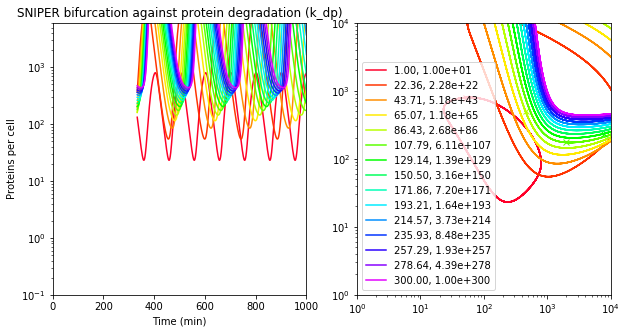

In [27]:
### SNIPER bifurcation against protein degradation (k_dp)
tl='SNIPER bifurcation against protein degradation (k_dp)';
dot=sdot;

rate_m_LacI_prod,
               rate_m_TetR_prod,
               rate_m_CI_prod,
               rate_m_LacI_loss,
               rate_m_TetR_loss,
               rate_m_CI_loss,
               rate_p_LacI_prod,
               rate_p_TetR_prod,
               rate_p_CI_prod,
               rate_p_LacI_loss,
               rate_p_TetR_loss,
               rate_p_CI_loss,
IPTG=0;
exec(cmd_init_name)
# var_ind=vardict['p_LacI'];
# varname.pop(var_ind);
# cstname.append('p_LacI');
exec(cmd_name2dict)
cmd_unpack_all=make_unpack_cmd(varname,cstname);
cmd_pack_all=make_pack_cmd(varname,cstname);
cmd_init_all=make_init_cmd(varname,cstname);
cmd_unpack_obs=make_unpackobs_cmd(vardict)
nt=1;
lc_step = 40000*nt;


siz=15;


for i,log_par in enumerate(np.linspace(1,300,siz)):
    col=cm(1.*i/(siz));
    lbl='%2.2f, %1.2e'%(log_par,10**(log_par))
    exec(cmd_default_param)
    exec(cmd_default_incond)
#     k_dp=10**(log_par)
    cpnum = log_par;
#     cpnum = 10**log_par
    exec(cmd_init_all)
    
    t_max=1000.*60.
    t_obs=np.linspace(0,t_max,nt*t_max+1)
    s_obs=odeint(sdot,s0,t_obs,args=(param,))
    
    t_obs=t_obs[-lc_step:]   
    s_obs=s_obs[-lc_step:,:]
    exec(cmd_unpack_obs)
    ys=p_LacI_obs;
    period = fft_period(ys,debug=0)/nt;
    amp=ys.max()-ys.min()
    avg=ys[-int(period*nt):].mean();
    print('log_par = {}, period estimate: {:f}, amplitude:{:f}, mean_LacI:{:f}'.format(str(log_par),period,amp,avg))
    


    axL.plot(t_obs/60,p_LacI_obs,'r',label = 'LacI',color=col)
#     axL.plot(t_obs/60,p_TetR_obs,'orange', label = 'TetR')
#     axL.plot(t_obs/60,p_CI_obs,'b', label = 'lambda_CI')
    #     axL.legend()

    axR.plot(p_CI_obs,p_LacI_obs,color=col,label=lbl)
    axR.plot(p_CI_obs[-1],p_LacI_obs[-1],'x',color=col)
    
axL.set_xlim(1E-1,1000)
axL.set_ylim(1E-1,6000)
axL.set_yscale('log')
axL.set_xlabel('Time (min)')
axL.set_ylabel('Proteins per cell')
# axL.legend()
axR.set_xscale('log')
axR.set_yscale('log')
axR.set_xlim(1,1E4)
axR.set_ylim(1,1E4)
axR.legend()

In [26]:
# cmd_unpack_var='(' + ','.join(varname)+') ='+'s;';
# cmd_unpack_cst='(' + ','.join(cstname)+') ='+'param;';

def sdot0(s,t,param):

#     (p_LacI, p_TetR, p_CI, m_LacI, m_TetR, m_CI, m_GFP, p_GFP)=s
#     (k_m, k_m0, k_p, k_dm, k_dp, K, n, k_dGFP, IPTG,fix_conc)=param
    exec(cmd_unpack_all)

#     if not fix_list==None:
#     print(fix_list)
    
#     for var_ind in fix_list:
#         cmd=varname[var_ind] + ' = (fix_conc[var_ind])';
#         exec(cmd);
#         print(cmd)
#         print(var_ind)
        
    dCIO_off=0;
    dLacO_off=0;
    dTetO_off=0;
    rate_m_LacI_prod =cpnum*( k_m*K**n / (K**n + p_CI**n)   + k_m0)
    rate_m_TetR_prod =cpnum*( k_m/ (1. + (p_LacI/K * ( 1. /(1.+IPTG/K_IPTG))**2 )**n) + k_m0)
    rate_m_CI_prod   =cpnum*( k_m*K_TetO**n / (K_TetO**n + p_TetR**n) + k_m0)
    rate_m_GFP_prod  = 0

    rate_p_LacI_prod = k_p*m_LacI
    rate_p_TetR_prod = k_p*m_TetR
    rate_p_CI_prod   = k_p*m_CI
    rate_p_GFP_prod  = 0

    rate_m_LacI_loss = k_dm*m_LacI
    rate_m_TetR_loss = k_dm*m_TetR
    rate_m_CI_loss   = k_dm*m_CI
    rate_m_GFP_loss  = 0

    rate_p_LacI_loss = k_dp*p_LacI
    rate_p_TetR_loss = k_dp*p_TetR
    rate_p_CI_loss   = k_dp*p_CI
    rate_p_GFP_loss  = 0

    dp_LacI = rate_p_LacI_prod - rate_p_LacI_loss
    dp_TetR = rate_p_TetR_prod - rate_p_TetR_loss
    dp_CI   = rate_p_CI_prod   - rate_p_CI_loss
    dp_GFP  = rate_p_GFP_prod  - rate_p_GFP_loss


    dm_LacI = rate_m_LacI_prod - rate_m_LacI_loss
    dm_TetR = rate_m_TetR_prod - rate_m_TetR_loss
    dm_CI   = rate_m_CI_prod   - rate_m_CI_loss
    dm_GFP  = rate_m_GFP_prod   - rate_m_GFP_loss

    exec(cmd_pack_all)
    return sdot